In [1]:
#importing libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


#reading the csv files

hsp3 = pd.read_csv("3hsp.csv")


#BZ = pd.read_csv("BZcat_only_classification.csv")
#fgl4= pd.read_csv("4fgl.csv")

#4fgl catalogue is stored in multiple txt files. Have to combine them all
fgl4_less= pd.read_csv("4fgl.csv")
fgl4_more = pd.read_csv("4fgl_.csv")
fgl4 = pd.merge(fgl4_less,fgl4_more,on="id ")
fgl4_cri= pd.read_csv("4fgl_alotmore.csv")
fgl4 = pd.merge(fgl4,fgl4_cri[['id ',' NuFNu 50-100 MeV (erg /cm2/s) ', ' NuFNu 100-300 MeV (erg /cm2/s) ',' NuFNu 300-1000 MeV (erg /cm2/s) ']],on="id ")

fgl4['total neutrino flux'] = 0.33*0.1*(fgl4[' NuFNu 1-3 GeV (erg /cm2/s) '] + fgl4[' NuFNu 3-10 GeV (erg /cm2/s) ']+
       fgl4[' NuFNu 10-30 GeV (erg /cm2/s) '] + fgl4[' NuFNu 30-300 GeV (erg /cm2/s)']+ fgl4[' NuFNu 50-100 MeV (erg /cm2/s) ']+ fgl4[' NuFNu 100-300 MeV (erg /cm2/s) ']+ fgl4[' NuFNu 300-1000 MeV (erg /cm2/s) '])

#3hsp some modifications 
hsp3[' X-ray flux d. @ 1keV (μJy) '] = pd.to_numeric(hsp3[' X-ray flux d. @ 1keV (μJy) '],errors='coerce')
hsp3[' X-ray flux d. @ 1keV (μJy) ']= hsp3[' X-ray flux d. @ 1keV (μJy) ']*2.4*(10**11)
hsp3[' X-ray flux d. @ 1keV (μJy) ']= hsp3[' X-ray flux d. @ 1keV (μJy) ']*(10**(-23))*0.33

#fhl3 = pd.read_csv("3fhl.csv")

#Defining 3 different functions for the 3 different regions  

#Bl_Lac region. The formula to get neutrino energy from BlLac. Padavoni paper 
def BL_Lac(vs_peak,z,delta):
    a = (17.5 )/(1+z)**2 
    b = (delta/10)**2
    c = (vs_peak)/(10**16)
    return(1000*(a*b)/c)
    #return(vs_peak+z+delta)
#BL_Lac(1.0,1.0,1.0)


#Fsrq_ blazarzone. The formula to get neutrino energy from FSRQ blazarzone Murase paper
def FSRQ_Blazarzone(E_s,Gamma):
    a = 80*Gamma**2
    b = (E_s/10)
    return(1000*a/b)


#fsrq_BLR region. The formula to get neutrino energy from FSRQ BLRegion Murase paper 
def FSRQ_BLR(E_BL , delta_epsilon):
    a = 0.05*(0.5*(1.6*10**(-27))*(3*(10**8))**2)*delta_epsilon
    return(a/E_BL)

#converting sync prak from our frame to emitted frame 
def frame_conversion(red_shift,syn_peak):
    log_syn_peak_emitted = np.log10(syn_peak)+np.log10(1+z)
    return( log_syn_peak_emitted )

#angular distance difference ka code . For 2 point sources 
def angular_dist(r1, d1, r2, d2):
    a = np.sin(np.abs(d1 - d2)/2)**2
    b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
    return 2*np.arcsin(np.sqrt(a + b))

#crossmatching code for 2 array of data. Take any 2 arrays - use this code to get the crossmatched index from both the arrays 
def crossmatch_tree(coords1, coords2, max_of_radius):
    #start_time = time()
    max_radius = max_of_radius
    matches = []
    no_matches = []
    
    # Convert to astropy coordinates objects
    coords1_sc = SkyCoord(coords1*u.degree, frame='icrs')
    coords2_sc = SkyCoord(coords2*u.degree, frame='icrs')
    
    # Perform crossmatching
    closest_ids, closest_dists, _ = coords1_sc.match_to_catalog_sky(coords2_sc)
    
    for id1, (closest_id2, dist) in enumerate(zip(closest_ids, closest_dists)):
        closest_dist = dist.value
        # Ignore match if it's outside the maximum radius
        if closest_dist > max_radius:
            no_matches.append(id1)
        else:
            matches.append([id1, closest_id2, closest_dist])
    return(matches,no_matches)

In [2]:
#JUst merging 3hsp and 4fgl using column names and pandas

#hsp3 = hsp3.replace(r'^\s*$', np.NaN, regex=True)
fgl4 = fgl4.replace(r'^\s*$', np.NaN, regex= True)
#BZ = BZ.replace(r'^\s*$', np.NaN, regex=True)

#converting sync_peak from log to normal units 

hsp3[' log(peak energy) '] = pd.to_numeric(hsp3[' Log(peak flux) '],errors='coerce')
hsp3[' peak_energy '] = 10**hsp3[' log(peak energy) ' ]
hsp3['redshift1'] = pd.to_numeric(hsp3[' Redshift '],errors='coerce')

hsp3['peak_energy_in_eV']=hsp3[' peak_energy ']*(4.135*(10**(-15)))
fgl4[' γ-ray counterpart '] = fgl4[' Source Name _x']


#finally running the code to get values for the 3 functions corresponding to each entry (bad english )7

hsp3['if_BLLac'] = BL_Lac(hsp3[' peak_energy '],hsp3['redshift1'], 15.0 )

#hsp3['if_FSRQ_BR']= FSRQ_Blazarzone(hsp3['peak_energy_in_eV'],10.0)

I_db = pd.merge(hsp3,fgl4, on = ' γ-ray counterpart ' , how = 'left')

I_db = I_db.replace(r'^\s*$', np.NaN, regex=True)

#df1['if_BLLac'] = BL_Lac(df[' peak_energy '],df['redshift1'], 15.0 ) # need to see what bcu is 
BL_Lac = I_db.loc[(I_db[' Class ']==' bll ') | (I_db[' Class '] == ' BLL ')]
BL_Lac = BL_Lac.replace(r'^\s*$', np.NaN, regex=True)

FSRQ = I_db.loc[(I_db[' Class ']==' fsrq ')]
FSRQ = FSRQ.replace(r'^\s*$', np.NaN, regex=True)

BCU = I_db.loc[(I_db[' Class ']==' bcu ')]
BCU = BCU.replace(r'^\s*$', np.NaN, regex=True)
BL_Lac = BL_Lac.loc[BL_Lac['if_BLLac'].notnull()]
I_db

,id _x,3HSP Source name,BZcat name,R.A.,Dec,NVSS/FIRSTflux density(mJy),Redshift,X-ray flux d. @ 1keV (μJy),Log(peak flux),FOM,...,Flux 10-30 GeV (ph/cm2/s),Flux 30-300 GeV (ph/cm2/s),NuFNu 1-3 GeV (erg /cm2/s),NuFNu 3-10 GeV (erg /cm2/s),NuFNu 10-30 GeV (erg /cm2/s),NuFNu 30-300 GeV (erg /cm2/s),NuFNu 50-100 MeV (erg /cm2/s),NuFNu 100-300 MeV (erg /cm2/s),NuFNu 300-1000 MeV (erg /cm2/s),total neutrino flux
0,1,3HSPJ000116.4+293534,NaN,0.31821,29.59278,4,0.58,NaN,16?,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3HSPJ000117.1-315043,NaN,0.32117,-31.84528,7.2,0.45,1.821600e-13,15.5?,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3HSPJ000132.7-415525,NaN,0.38642,-41.92361,13.2,NaN,2.692800e-13,15.8,0.79,...,<8.847e-12,<7.089e-12,2.075000e-12,3.673000e-13,1.594000e-16,1.312000e-17,9.694000e-12,8.493000e-12,5.048000e-12,8.473566e-13
3,4,3HSPJ000158.1-115047,NaN,0.49225,-11.84639,3.3,0.53,8.712000e-14,16.2,0.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3HSPJ000215.2-672653,NaN,0.56329,-67.44806,21.4,0.52,2.138400e-13,15.8,0.63,...,2.510e-11,1.855e-11,3.785000e-13,6.201000e-13,6.131000e-13,1.061000e-12,1.661000e-12,7.174000e-13,2.088000e-13,1.735767e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,2009,3HSPJ235907.9-303740,5BZBJ2359-3037,359.78283,-30.62778,66.7,0.165,1.001088e-11,17.1,3.98,...,2.219e-12,<4.841e-12,8.559000e-13,2.168000e-13,5.092000e-14,1.071000e-16,5.551000e-16,6.634000e-13,9.121000e-13,8.909281e-14
2009,2010,3HSPJ235917.0+021520,NaN,359.82100,2.25556,5,NaN,7.920000e-14,16.4,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,2011,3HSPJ235919.5-204756,NaN,359.83138,-20.79889,472.7,0.096,1.900800e-13,16.2,0.25,...,4.835e-11,1.066e-11,7.368000e-12,3.247000e-12,1.044000e-12,3.424000e-13,5.013000e-13,1.802000e-14,1.005000e-11,7.448338e-13
2011,2012,3HSPJ235921.3-131129,NaN,359.83892,-13.19139,30.4,0.56,5.544000e-14,15.7,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


16488.569135100042


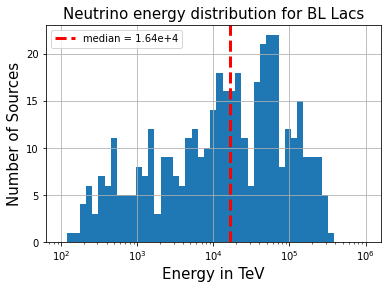

In [3]:
#for 3hsp and 4fgl 
#BL_Lac.hist(column='if_BLLac', log=True)
#histogram for Bl lac's neutrino energy. Made a seperate table of the blazars which are all bllacs 
print(BL_Lac['if_BLLac'].median())
plt.hist(BL_Lac['if_BLLac'], bins=np.logspace(np.log10(100.0),np.log10(1000000.0), 50))
plt.axvline(BL_Lac['if_BLLac'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 1.64e+4')



plt.gca().set_xscale("log")
plt.xlabel('Energy in TeV',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Neutrino energy distribution for BL Lacs',fontsize='15')
plt.legend()

plt.show()


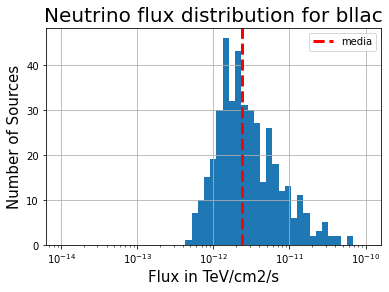

In [4]:
#histogram for neutrino flux distribution of bllacs. This data is from 3hsp catalogue
plt.hist(0.624*BL_Lac[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) '],bins=np.logspace(-14,-10, 50))
plt.axvline(0.624*BL_Lac[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) '].median(), color='r', linestyle='dashed', linewidth=3,label='media')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV/cm2/s',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Neutrino flux distribution for bllac',fontsize='20')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Neutrino flux distribution for Bl-Lacs  ')

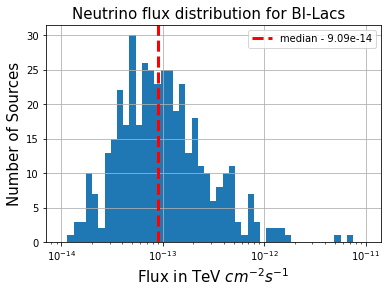

In [5]:
#histogram for neutrino flux distribution of bllacs. This data is from 4fgl catalogue
plt.hist(0.624*BL_Lac['total neutrino flux'],bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(0.624*BL_Lac['total neutrino flux'].median(), color='r', linestyle='dashed', linewidth=3,label='median - 9.09e-14')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution for Bl-Lacs  ',fontsize='15')

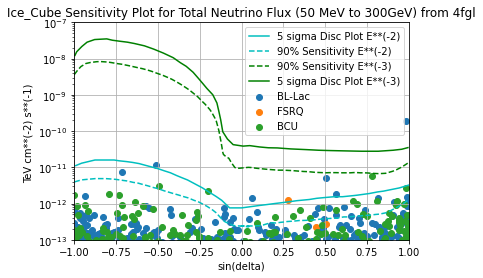

In [6]:
df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')
df2 = pd.read_csv('3cubed_90.csv')
df3 = pd.read_csv('esquared_90.csv')

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Total Neutrino Flux (50 MeV to 300GeV) from 4fgl')
plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')

plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BL_Lac[' Dec ']),0.642*BL_Lac['total neutrino flux'],label='BL-Lac')
plt.scatter(np.sin(FSRQ[' Dec ']),0.642*FSRQ['total neutrino flux'],label='FSRQ')
plt.scatter(np.sin(BCU[' Dec ']),0.642*BCU['total neutrino flux'],label='BCU')

plt.legend()
plt.grid()
plt.show()

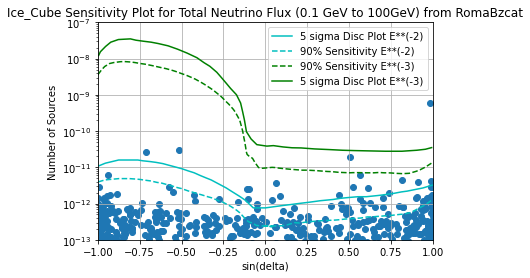

In [7]:

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Total Neutrino Flux (0.1 GeV to 100GeV) from RomaBzcat')

plt.xlabel('sin(delta)')
plt.ylabel('Number of Sources')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(BL_Lac[' Dec ']),0.642*0.1*BL_Lac[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) ']);

plt.legend()
plt.grid()
plt.show()

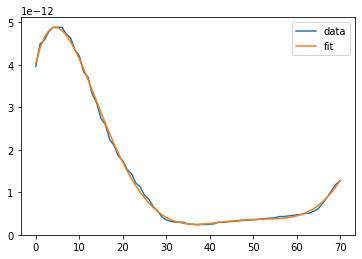

In [8]:
#using poly fit to fit the line ice cube sensitivity. Using 6th order polynomial fit 
x = np.linspace(-1.0,1.0,71)
poly1 = np.polyfit(x, df3['y'], deg=6)

fig, ax = plt.subplots()
ax.plot(df3['y'], label='data')
#ax.plot(np.polyval(poly, x), label='fit')
ax.plot(np.polyval(poly1, x), label='fit')
ax.legend()


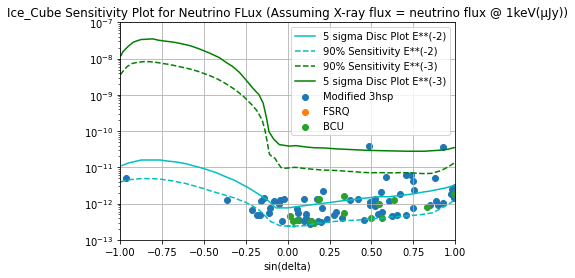

In [9]:
BL_Lac_new = BL_Lac.loc[(BL_Lac[' X-ray flux d. @ 1keV (μJy) ']*0.642)>np.polyval(poly1, np.sin(BL_Lac[' Dec ']))] # 106 survive out of 418 - 25.98% 
FSRQ_new = FSRQ.loc[(FSRQ[' X-ray flux d. @ 1keV (μJy) ']*0.624)>np.polyval(poly1, np.sin(FSRQ[' Dec ']))]
BCU_new = BCU.loc[(BCU[' X-ray flux d. @ 1keV (μJy) ']*0.624)>np.polyval(poly1, np.sin(BCU[' Dec ']))]

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BL_Lac_new[' Dec ']),0.624*BL_Lac_new[' X-ray flux d. @ 1keV (μJy) '],label='Modified 3hsp');
plt.scatter(np.sin(FSRQ_new[' Dec ']),0.642*FSRQ_new[' X-ray flux d. @ 1keV (μJy) '],label='FSRQ')
plt.scatter(np.sin(BCU_new[' Dec ']),0.642*BCU_new[' X-ray flux d. @ 1keV (μJy) '],label='BCU')

plt.legend();

plt.grid()
plt.show()

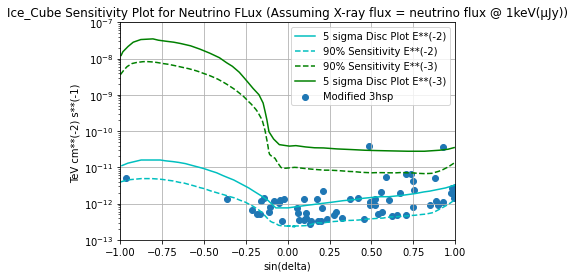

In [10]:
BL_Lac[' X-ray flux d. @ 1keV (μJy) ']=BL_Lac[' X-ray flux d. @ 1keV (μJy) ']*0.642
BL_Lac_new = BL_Lac.loc[(BL_Lac[' X-ray flux d. @ 1keV (μJy) '])>np.polyval(poly1, np.sin(BL_Lac[' Dec ']))] # 106 survive out of 418 - 25.98% 

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BL_Lac_new[' Dec ']),BL_Lac_new[' X-ray flux d. @ 1keV (μJy) '],label='Modified 3hsp');
plt.legend();

plt.grid()
#plt.show()

In [11]:


BL_Lac_fsrq=BL_Lac_new.loc[BL_Lac_new[' Class ']==' fsrq ']
BL_Lac_bllac=BL_Lac_new.loc[BL_Lac_new[' Class ']==' bll ']
BL_Lac_bcu=BL_Lac_new.loc[BL_Lac_new[' Class ']==' bcu ']

2.3897808e-13


Text(0.5, 1.0, 'Neutrino flux distribution from X Ray flux   ')

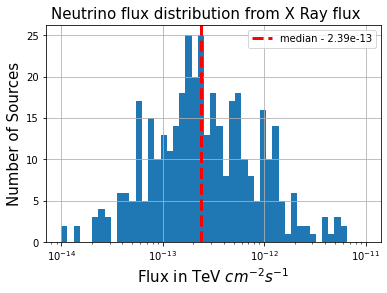

In [12]:
print(BL_Lac[' X-ray flux d. @ 1keV (μJy) '].median())
plt.hist(BL_Lac[' X-ray flux d. @ 1keV (μJy) '],bins=np.logspace(-14,-11, 50)) #50MeV to 300GeV 
plt.axvline(BL_Lac[' X-ray flux d. @ 1keV (μJy) '].median(), color='r', linestyle='dashed', linewidth=3,label='median - 2.39e-13')

plt.gca().set_xscale("log")
plt.xlabel('Flux in TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.legend()
plt.title('Neutrino flux distribution from X Ray flux   ',fontsize='15')

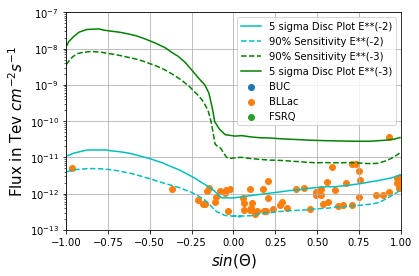

In [13]:

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
#plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('$sin({\Theta})$',fontsize='15')
plt.ylabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')

plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BL_Lac_bcu[' Dec ']),BL_Lac_bcu[' X-ray flux d. @ 1keV (μJy) '],label='BUC')
plt.scatter(np.sin(BL_Lac_bllac[' Dec ']),BL_Lac_bllac[' X-ray flux d. @ 1keV (μJy) '],label='BLLac')
plt.scatter(np.sin(BL_Lac_fsrq[' Dec ']),BL_Lac_fsrq[' X-ray flux d. @ 1keV (μJy) '],label='FSRQ');

plt.legend();

plt.grid()
plt.show()

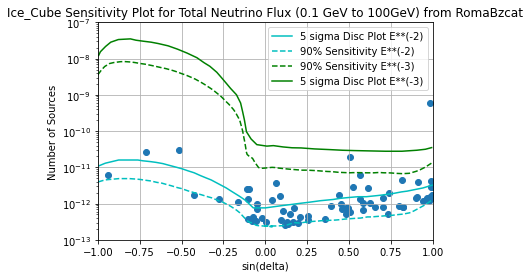

In [14]:
BL_Lac[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) ']=BL_Lac[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) ']*0.1*0.642
BL_Lac_new = BL_Lac.loc[(BL_Lac[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) '])>np.polyval(poly1, np.sin(BL_Lac[' Dec ']))] # 106 survive out of 418 - 25.98% 

df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Total Neutrino Flux (0.1 GeV to 100GeV) from RomaBzcat')

plt.xlabel('sin(delta)')
plt.ylabel('Number of Sources')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BL_Lac_new[' Dec ']),BL_Lac_new[' 0.1-100 GeV Energy Flux (erg cm-2 s-1) ']);

plt.legend()
plt.grid()
plt.show()

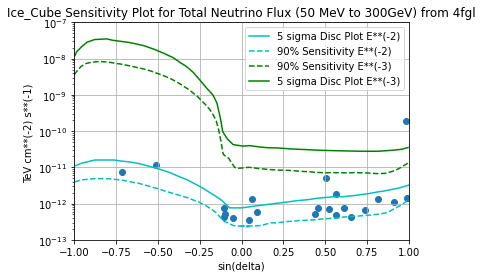

In [15]:
BL_Lac['total neutrino flux']=BL_Lac['total neutrino flux']*0.624
BL_Lac_new = BL_Lac.loc[(BL_Lac['total neutrino flux'])>np.polyval(poly1, np.sin(BL_Lac[' Dec ']))] # 106 survive out of 418 - 25.98% 

df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')
df3 = pd.read_csv('esquared_90.csv')

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Total Neutrino Flux (50 MeV to 300GeV) from 4fgl')
plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(BL_Lac_new[' Dec ']),BL_Lac_new['total neutrino flux']);

plt.legend()
plt.grid()
plt.show()

In [16]:
#function for differential neutrino flux at the neutrino synchrotron peak energy.
#Variables are the neutrino sed peak,  gamma ray flux, spectral index(one_to is one minus the spectral index ) 

def neutrino_flux(gammaray_flux,one_to , neutrino_sed):
    E2_mu = 10000.0
    E1_mu = 30.0 
    k = (1+one_to)/(E2_mu**(1+one_to) - E1_mu**(1+one_to))
    c = gammaray_flux*k
    return(c*(neutrino_sed**(one_to)))

In [17]:
BL_Lac_new = BL_Lac
BL_Lac_new['final_thing'] = neutrino_flux(BL_Lac_new['total neutrino flux'],-2.0,BL_Lac_new['if_BLLac'])
BL_Lac_new_new = BL_Lac_new.loc[BL_Lac_new['if_BLLac'] < 10000.0]

<AxesSubplot:ylabel='Frequency'>

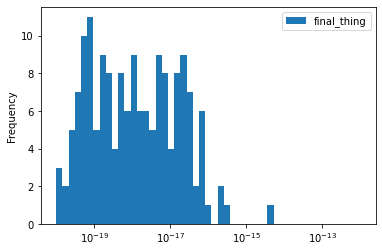

In [18]:
BL_Lac_new_new.loc[(BL_Lac_new_new['final_thing'] > 10**-20), ['final_thing']].plot(kind='hist',logx=True,bins=np.logspace(-20,-12, 50))

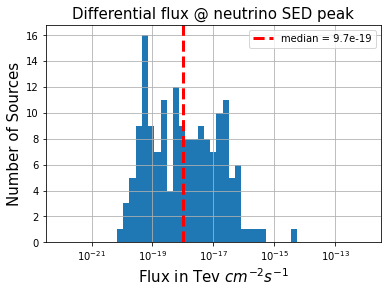

In [19]:
plt.xscale("log")
plt.title('Differential flux @ neutrino SED peak',fontsize='15')

plt.xlabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')

plt.hist(BL_Lac_new_new['final_thing'],bins=np.logspace(-22,-12, 50));
plt.axvline(BL_Lac_new_new['final_thing'].median(), color='r', linestyle='dashed', linewidth=3,label='median = 9.7e-19' )
plt.legend()
plt.grid()
plt.show()

In [20]:
def neutrino_flux2(gammaray_flux,gamma , neutrino_sed):
    time = 3.15*10**8
    effectivearea = 10**7
    E2_mu = 10000.0
    E1_mu = 30.0
    k = (2-gamma)/(E2_mu**(2-gamma) - E1_mu**(2-gamma))
    c = gammaray_flux*k*time*effectivearea
    return(c*(neutrino_sed**(-gamma)))

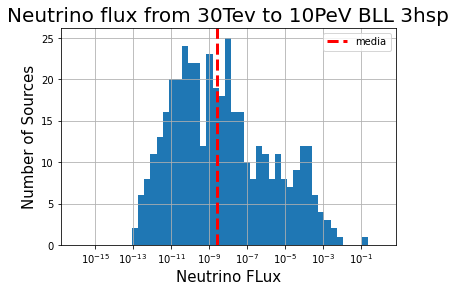

In [21]:
BL_Lac_new['final_neutrinoflux'] = neutrino_flux2(BL_Lac_new['total neutrino flux'],3,BL_Lac_new['if_BLLac'])

plt.xscale("log")
plt.title('Neutrino flux from 30Tev to 10PeV BLL 3hsp',fontsize='20')

plt.xlabel('Neutrino FLux',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')

plt.hist(BL_Lac_new['final_neutrinoflux'],bins=np.logspace(-16,0, 50));
plt.axvline(BL_Lac_new['final_neutrinoflux'].median(), color='r', linestyle='dashed', linewidth=3,label='media')
plt.legend()
plt.grid()
plt.show()

In [22]:
different = I_db
differnet = different.replace(r'^\s*$', np.NaN, regex=True)

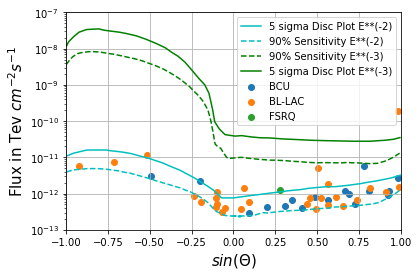

In [23]:
different_new = different
different_new['total neutrino flux']=different_new['total neutrino flux']*0.64
#different_new= different.loc[(different['total neutrino flux'])>np.polyval(poly1, np.sin(different[' Dec ']))] # 106 survive out of 418 - 25.98% 

different_new_bcu=different_new.loc[different_new[' Class ']==' bcu ']
different_new_bcu = different_new_bcu.loc[(different_new_bcu['total neutrino flux'])>np.polyval(poly1, np.sin(different_new_bcu[' Dec ']))] #lsp 89 survive out of 810 - 10.98%

different_new_bllac=different_new.loc[ different_new[' Class ']==' bll '  ]
different_new_bllac = different_new_bllac.loc[(different_new_bllac['total neutrino flux'])>np.polyval(poly1, np.sin(different_new_bllac[' Dec ']))] #hsp 20 survive out of 243 -  8.23% 

different_new_fsrq=different_new.loc[different_new[' Class ']==' fsrq ']
different_new_fsrq = different_new_fsrq.loc[(different_new_fsrq['total neutrino flux'])>np.polyval(poly1, np.sin(different_new_fsrq[' Dec ']))]

df = pd.read_csv('e3_sensitivity.csv')
df1 = pd.read_csv('e2_sensitivity_datapoints.csv')
df3 = pd.read_csv('esquared_90.csv')

plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
#plt.title('Ice_Cube Sensitivity Plot for Total Neutrino Flux (50 MeV to 300GeV) from 4fgl')
plt.xlabel('$sin({\Theta})$',fontsize='15')
plt.ylabel('Flux in Tev $cm^{-2} s^{-1}$',fontsize='15')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')
plt.scatter(np.sin(different_new_bcu[' Dec ']),different_new_bcu['total neutrino flux'],label='BCU');
plt.scatter(np.sin(different_new_bllac[' Dec ']),different_new_bllac['total neutrino flux'],label='BL-LAC');
plt.scatter(np.sin(different_new_fsrq[' Dec ']),different_new_fsrq['total neutrino flux'],label='FSRQ');

plt.legend()
plt.grid()
plt.show()

In [24]:
different_new_bcu=different_new.loc[different_new[' Class ']==' bcu ']
different_new_bllac=different_new.loc[ different_new[' Class ']==' bll '  ]
different_new_fsrq=different_new.loc[different_new[' Class ']==' fsrq ']


In [25]:
different_new_bllac #17 bcu out of 251 # 1 fsrq out of 5# 28 bllac out of 496

,id _x,3HSP Source name,BZcat name,R.A.,Dec,NVSS/FIRSTflux density(mJy),Redshift,X-ray flux d. @ 1keV (μJy),Log(peak flux),FOM,...,Flux 10-30 GeV (ph/cm2/s),Flux 30-300 GeV (ph/cm2/s),NuFNu 1-3 GeV (erg /cm2/s),NuFNu 3-10 GeV (erg /cm2/s),NuFNu 10-30 GeV (erg /cm2/s),NuFNu 30-300 GeV (erg /cm2/s),NuFNu 50-100 MeV (erg /cm2/s),NuFNu 100-300 MeV (erg /cm2/s),NuFNu 300-1000 MeV (erg /cm2/s),total neutrino flux
11,12,3HSPJ000835.4-233927,5BZBJ0008-2339,2.14742,-23.65750,36.3,0.147,3.722400e-13,17,0.79,...,4.101e-12,1.760e-12,3.176000e-13,1.898000e-13,9.456000e-14,7.989000e-14,7.371000e-13,9.235000e-13,3.210000e-13,5.625206e-14
12,13,3HSPJ000922.7+503028,5BZBJ0009+5030,2.34479,50.50778,12.3,0.25,1.267200e-13,15.1,0.63,...,6.356e-12,<6.492e-12,1.592000e-13,2.721000e-13,1.502000e-13,2.415000e-17,9.874000e-13,2.189000e-13,2.216000e-13,4.243904e-14
13,14,3HSPJ000949.7-431650,NaN,2.45729,-43.28056,51,0.23,2.455200e-13,15.3,0.40,...,7.604e-12,<5.213e-12,2.579000e-13,3.433000e-13,1.737000e-13,1.272000e-18,2.519000e-13,2.495000e-12,5.176000e-13,8.531215e-14
19,20,3HSPJ001356.0-185406,5BZGJ0013-1854,3.48350,-18.90167,29.6,0.094,1.599840e-12,17.4,2.00,...,2.825e-11,9.659e-12,6.632000e-13,7.720000e-13,6.710000e-13,4.921000e-13,7.173000e-17,2.608000e-13,1.034000e-12,8.222379e-14
20,21,3HSPJ001411.5-502234,5BZBJ0014-5022,3.54771,-50.37611,15.1,0.01,8.870400e-13,17.5,1.00,...,<6.757e-12,<4.861e-12,4.347000e-13,1.175000e-13,1.945000e-17,1.830000e-16,3.110000e-12,7.387000e-13,4.742000e-13,1.029664e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,2004,3HSPJ235612.2+403644,5BZGJ2356+4036,359.05067,40.61222,25,0.331,NaN,16.3,0.32,...,2.324e-12,<3.837e-12,4.644000e-13,2.929000e-14,5.263000e-14,1.140000e-17,3.125000e-12,1.119000e-12,9.060000e-13,1.203065e-13
2005,2006,3HSPJ235730.0-171803,5BZBJ2357-1718,359.37487,-17.30083,44.5,0.85,1.615680e-12,17.6,1.58,...,2.905e-12,1.319e-12,1.118000e-12,7.652000e-13,6.676000e-14,5.915000e-14,3.488000e-13,1.464000e-14,1.182000e-12,7.507210e-14
2006,2007,3HSPJ235825.2+382856,NaN,359.60496,38.48222,58,0.24,NaN,16.1,0.50,...,5.379e-11,1.183e-12,4.445000e-12,3.222000e-12,1.121000e-12,3.333000e-14,9.378000e-13,3.465000e-12,2.978000e-13,2.855832e-13
2008,2009,3HSPJ235907.9-303740,5BZBJ2359-3037,359.78283,-30.62778,66.7,0.165,1.001088e-11,17.1,3.98,...,2.219e-12,<4.841e-12,8.559000e-13,2.168000e-13,5.092000e-14,1.071000e-16,5.551000e-16,6.634000e-13,9.121000e-13,5.701940e-14


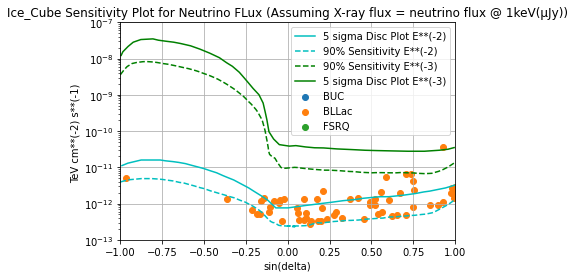

In [26]:
plt.ylim(10**(-13),10**(-7))
plt.xlim(-1.0,1.0)

plt.yscale("log")
plt.title('Ice_Cube Sensitivity Plot for Neutrino FLux (Assuming X-ray flux = neutrino flux @ 1keV(μJy))')

plt.xlabel('sin(delta)')
plt.ylabel('TeV cm**(-2) s**(-1) ')
plt.plot(df['x'],df[' y'],'c',label='5 sigma Disc Plot E**(-2)')
plt.plot(df3['x'],df3['y'],'--c',label='90% Sensitivity E**(-2)')
plt.plot(df2['x'],df2['y'],'--g',label='90% Sensitivity E**(-3)')
plt.plot(df1['x'],df1['y'],'g',label='5 sigma Disc Plot E**(-3)')

plt.scatter(np.sin(BL_Lac_bcu[' Dec ']),BL_Lac_bcu[' X-ray flux d. @ 1keV (μJy) '],label='BUC')
plt.scatter(np.sin(BL_Lac_bllac[' Dec ']),BL_Lac_bllac[' X-ray flux d. @ 1keV (μJy) '],label='BLLac')
plt.scatter(np.sin(BL_Lac_fsrq[' Dec ']),BL_Lac_fsrq[' X-ray flux d. @ 1keV (μJy) '],label='FSRQ');

plt.legend();

plt.grid()
plt.show()

In [27]:
k = BL_Lac['if_BLLac']/(3.4*10**(8)*10*10000)
l = BL_Lac['if_BLLac']/(3.4*10**(8)*1000*10000)

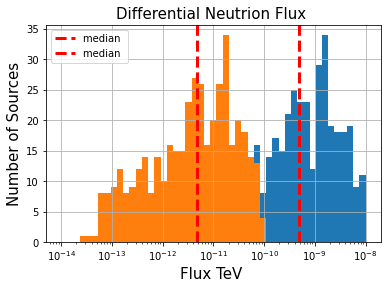

In [28]:
plt.hist(k, bins=np.logspace(-14,-8))
plt.axvline(k.median(), color='r', linestyle='dashed', linewidth=3,label='median ')
plt.hist(l, bins=np.logspace(-14,-8))#, bins=np.logspace(np.log10(100.0),np.log10(1000000.0), 50))
plt.axvline(l.median(), color='r', linestyle='dashed', linewidth=3,label='median ')

plt.gca().set_xscale("log")
plt.xlabel('Flux TeV ',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Differential Neutrion Flux ',fontsize='15')
plt.legend()

plt.show()

In [29]:
#----------------------------------------------
#this function is to get the value of the value of the effective area of icecube 
def FindSorted(array,value):
    left = 0 
    right = len(array)
    while(left < right - 1 ):
        koun = left 
        middle = int((left+right)/2 )
        if(array[middle] >= value ):
            right = middle 
        else:
            left = middle 
    #if( right < len(array) & left < len(array) ):
    return koun 
    #else : 
     #   return(math.nan)
        
def FindSorted1(array,value,array2):
    index = FindSorted(array,value)
    return array2[index]

In [30]:
#effective area for different levels of sensitivity are taken from the "" . The declination values for the same are mentioned next to the code
data1 = pd.read_csv("a30-85.csv") # declination 30 degrees to 85 degrees 
data1['energy']=(10**(data1['energy'])/1000)
data2 = pd.read_csv("an5-30.csv")# declination -5 degrees to 30 degrees 
data2['energy']=(10**(data2['energy'])/1000)
data3 = pd.read_csv("an30n5.csv")# declination -30 degrees to -5 degrees 
data3['energy']=(10**(data3['energy'])/1000)
data4 = pd.read_csv("an90n30.csv")# declination -90 degrees to -30 degrees 
data4['energy']=(10**(data4['energy'])/1000)
import math

In [31]:
Diff_flux_1event =  BL_Lac
Diff_flux_1event=Diff_flux_1event.reset_index()

In [32]:
for i in range(len(Diff_flux_1event)):
    if(30.0 <= Diff_flux_1event.loc[i," Dec "] < 90.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data1['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data1['area'])
    if(-5.0 <=  Diff_flux_1event.loc[i," Dec "] < 30.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data2['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data2['area'])
    if(-30.0 <=  Diff_flux_1event.loc[i," Dec "] < -5.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data3['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data3['area'])
    if(-90.0 <=  Diff_flux_1event.loc[i," Dec "] < -30.0):
        Diff_flux_1event.loc[i,"zero"] = FindSorted1(data4['energy'], Diff_flux_1event.loc[i,"if_BLLac"],data4['area'])    


In [33]:
Diff_flux_1event['diff_flux'] = Diff_flux_1event['if_BLLac']/(10000*Diff_flux_1event['zero']*(3.45*10**(8)))

No handles with labels found to put in legend.


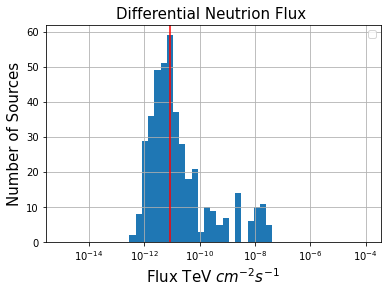

In [34]:
plt.hist(Diff_flux_1event['diff_flux'], bins=np.logspace(-15,-4))
plt.axvline(Diff_flux_1event['diff_flux'].median(),color='r')

plt.gca().set_xscale("log")
plt.xlabel('Flux TeV $cm^{-2} s^{-1}$',fontsize='15')
plt.ylabel('Number of Sources',fontsize='15')
plt.grid()
plt.title('Differential Neutrion Flux ',fontsize='15')
plt.legend()

plt.show()